In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base= automap_base()

# reflect the tables

Base.prepare(engine, reflect= True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement= Base.classes.measurement

Station= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session=Session(engine)

# Exploratory Climate Analysis

In [12]:
# Inspect tables

inspector= inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [14]:
# Get column names for Measurement
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Get column names for Station
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Latest Point
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Find all dates greater than 2016-08-23, one year prior to latest point
session.query(Measurement.date).\
    filter(Measurement.date > "2016-08-23").\
    order_by(Measurement.date).all()


[('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-24'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-25'),
 ('2016-08-26'),
 ('2016-08-26'),
 ('2016-08-26'),
 ('2016-08-26'),
 ('2016-08-26'),
 ('2016-08-26'),
 ('2016-08-27'),
 ('2016-08-27'),
 ('2016-08-27'),
 ('2016-08-27'),
 ('2016-08-27'),
 ('2016-08-27'),
 ('2016-08-28'),
 ('2016-08-28'),
 ('2016-08-28'),
 ('2016-08-28'),
 ('2016-08-28'),
 ('2016-08-28'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-29'),
 ('2016-08-30'),
 ('2016-08-30'),
 ('2016-08-30'),
 ('2016-08-30'),
 ('2016-08-30'),
 ('2016-08-30'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-08-31'),
 ('2016-09-01'),
 ('2016-09-01'),
 ('2016-09-01'),
 ('2016-09-01'),
 ('2016-09-01'),
 ('2016-09-01'),
 ('2016-09-02'

In [18]:
# Perform a query to retrieve the data and precipitation scores
sel= [Measurement.date, Measurement.prcp]
measurement= session.query(*sel)
    

In [39]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df= pd.DataFrame(measurement, columns=["date", "prcp"])
df.set_index("date", inplace=True)

# Sort the dataframe by date and drop nulls
df.sort_index(ascending=True)
df=df.dropna()
df.head()


,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-07,0.06


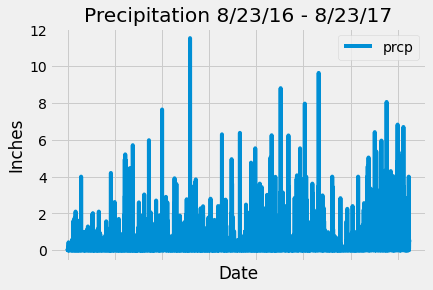

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1 = df.plot.line()

plt.tick_params(
    axis='x',         
    which='both',     
    bottom=False,     
    top=False,         
    labelbottom=False) 

plt.title(f"Precipitation 8/23/16 - 8/23/17")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [34]:
# Design a query to show how many stations are available in this dataset
session.query(Station.id).count() 

9

In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]

most_active = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

active_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

active_station

(54.0, 85.0, 71.66378066378067)

Lowest temp= 54
Highest temp= 85
Average temp= 71.66

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_query = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active [0][0]).\
    filter(Measurement.date >= "2016-08-23").all()

temps = list(np.ravel(temp_query))

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_query = session.query(*sel).all()
stations_df = pd.DataFrame(station_query, columns=['Station','Name','Latitude','Longitude','Elevation'])

temp_station = stations_df.loc[stations_df["Station"] == most_active[0][0],"Name"].tolist()[0]
temp_station

'WAIHEE 837.5, HI US'

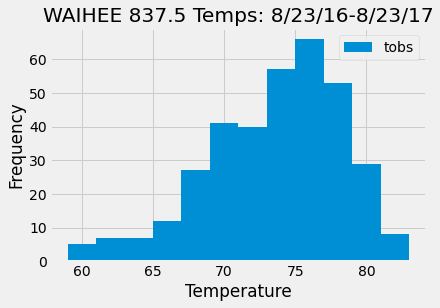

In [57]:
# Plot histogram
plt.hist(temps, bins=12,rwidth=1.0,label='tobs')
plt.title(f"WAIHEE 837.5 Temps: 8/23/16-8/23/17")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
